In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from tabulate import tabulate
from io import StringIO

C:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('EDA-Fase3.csv')
df.head()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15684\1165319363.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('EDA-Fase3.csv')


,Region,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,Frontage,FrontageIsGreaterFlag,TotalFloorArea,...,Prefecture_shizuoka prefecture,Prefecture_tochigi prefecture,Prefecture_tokushima prefecture,Prefecture_tokyo,Prefecture_tottori prefecture,Prefecture_toyama prefecture,Prefecture_wakayama prefecture,Prefecture_yamagata prefecture,Prefecture_yamaguchi prefecture,Prefecture_yamanashi prefecture
0,residential area,28.0,28.0,86000000,1100,False,78000.0,34.0,False,NaN,...,0,0,0,0,0,0,0,0,0,0
1,residential area,27.0,27.0,38000000,310,False,120000.0,21.5,False,NaN,...,0,0,0,0,0,0,0,0,0,0
2,NaN,20.0,20.0,19000000,95,False,NaN,NaN,False,NaN,...,0,0,0,0,0,0,0,0,0,0
3,residential area,26.0,26.0,5000000,290,False,17000.0,7.0,False,NaN,...,0,0,0,0,0,0,0,0,0,0
4,residential area,23.0,23.0,25000000,430,False,58000.0,16.0,False,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.columns.tolist()

['Region',
 'MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Breadth',
 'CoverageRatio',
 'FloorAreaRatio',
 'Year',
 'Quarter',
 'Renovation',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land and building)',
 'Type_residential land(land only)',
 'LandShape_flag-shaped etc.',
 'LandShape_irregular shaped',
 'LandShape_rectangular shaped',
 'LandShape_semi-rectangular shaped',
 'LandShape_semi-shaped',
 'LandShape_semi-square shaped',
 'LandShape_semi-trapezoidal shaped',
 'LandShape_square shaped',
 'LandShape_trapezoidal shaped',
 'Direction_east',
 'Direction_no facing road',
 'Direction_north',
 'Direction_northeast',
 'Direction_northwest',
 'Direction_south',
 'Direction_southeast',
 'Direction_southwest',
 'Direction_west',


Has the price of real estate in Japan increased/decreased in the last 10 years? (residential use)

In [4]:
#1 Filtrar datos por año y que sea de tipo residencial 'Type_residential land(land and building)' or  'Type_residential land(land only)',
# last year is 2019, so last ten year is >= 2009
filtered_df = df[(df['Year'] >= 2009)]
filtered_df = filtered_df[(filtered_df['Type_residential land(land and building)'] == 1) | (filtered_df['Type_residential land(land only)'] == 1)]
#2 Agrupar por año y calcular el precio promedio
price_trend = filtered_df.groupby("Year")["TradePrice"].mean().reset_index()

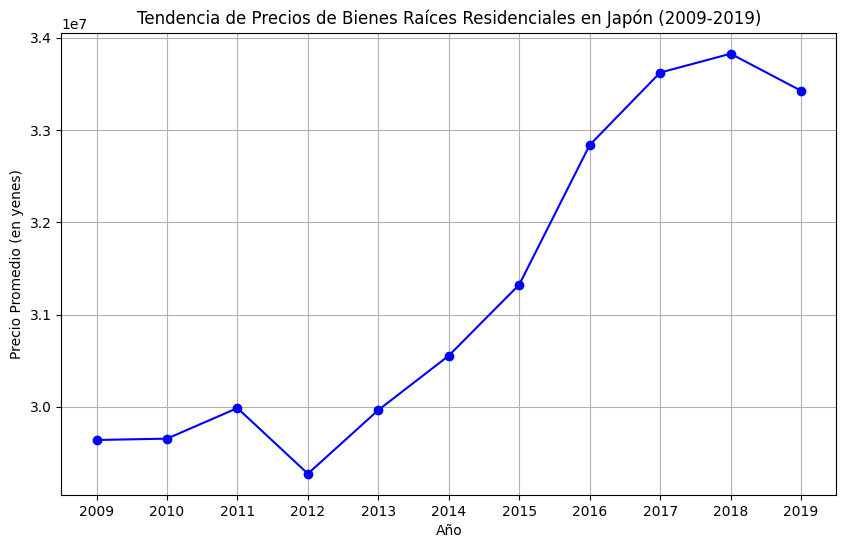

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(price_trend["Year"], price_trend["TradePrice"], marker='o', linestyle='-', color='b')
plt.title("Tendencia de Precios de Bienes Raíces Residenciales en Japón (2009-2019)")
plt.xlabel("Año")
plt.ylabel("Precio Promedio (en yenes)")
plt.xticks(price_trend["Year"])  
plt.grid()
plt.show()

Is there a price difference between Tokyo(Capital of Japan) and local areas?
the analysis will show comparations between Tokyo municipalities/wards inside Tokyo prefecture in 2019

In [6]:
df_tokyo = df[(df['Year'] == 2019) & (df['Prefecture_tokyo'] == 1)]

df_tokyo = df_tokyo.groupby("M")["TradePrice"].mean().reset_index()
df_tokyo = df_tokyo.sort_values(by="TradePrice")

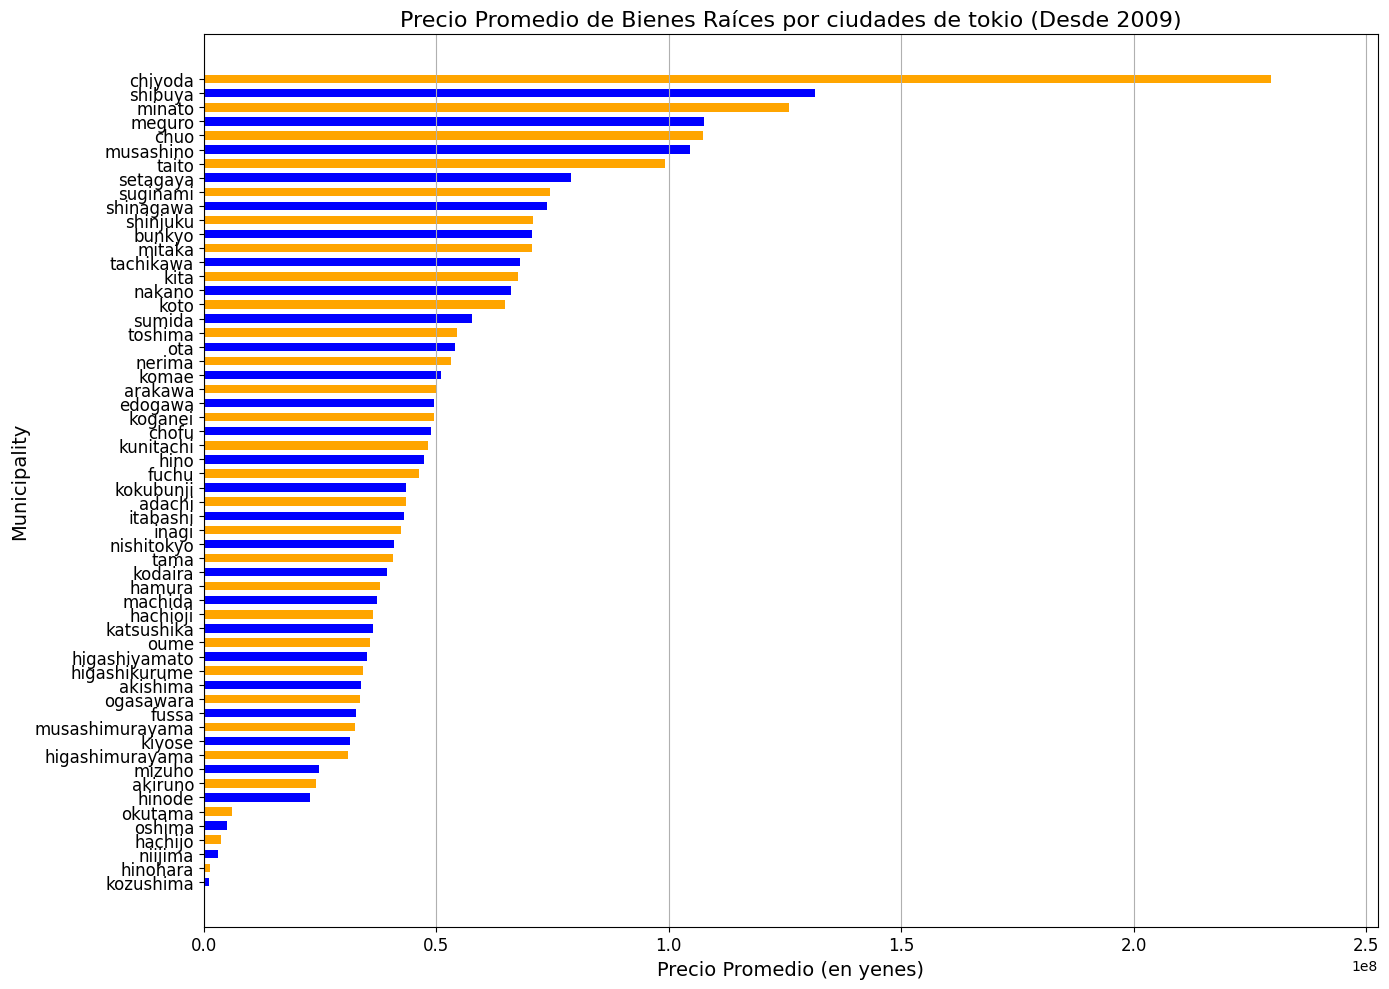

In [7]:

plt.figure(figsize=(14, 10))  
plt.barh(df_tokyo["M"], df_tokyo["TradePrice"], color=['blue', 'orange'], height=0.6) 
plt.title("Precio Promedio de Bienes Raíces por ciudades de tokio (Desde 2009)", fontsize=16)
plt.xlabel("Precio Promedio (en yenes)", fontsize=14)
plt.ylabel("Municipality", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  
plt.xlim(0, df_tokyo["TradePrice"].max() * 1.1) 
plt.grid(axis='x')
plt.tight_layout()  
plt.show()

A comparacion of prefectures prices is done

In [8]:
df_19 = df[(df['Year'] == 2019)]
prefecture_columns = [col for col in df_19.columns if col.startswith('Prefecture')]


In [9]:
df_19.columns

Index(['Region', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
       'TradePrice', 'Area', 'AreaIsGreaterFlag', 'UnitPrice', 'Frontage',
       'FrontageIsGreaterFlag', 'TotalFloorArea',
       ...
       'Prefecture_shizuoka prefecture', 'Prefecture_tochigi prefecture',
       'Prefecture_tokushima prefecture', 'Prefecture_tokyo',
       'Prefecture_tottori prefecture', 'Prefecture_toyama prefecture',
       'Prefecture_wakayama prefecture', 'Prefecture_yamagata prefecture',
       'Prefecture_yamaguchi prefecture', 'Prefecture_yamanashi prefecture'],
      dtype='object', length=158)

In [10]:
print(tabulate(df_19[prefecture_columns].head(), headers='keys', tablefmt='psql'))


+----+-------------------------------+-------------------------------+--------------------------------+-------------------------------+-------------------------------+-------------------------------+---------------------------------+-----------------------------------+------------------------------+-------------------------------+-----------------------------------+-----------------------+-------------------------------+---------------------------------+----------------------------------+-------------------------------+--------------------------------+-----------------------------------+----------------------------------+-------------------------------+----------------------------------+-------------------------------+-----------------------------+--------------------------------+----------------------------------+--------------------------------+----------------------------------+------------------------------+---------------------------------+------------------------------+----------

In [11]:
#reverting get dummies changes
df_19['Prefecture'] = df_19[prefecture_columns].idxmax(axis=1)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15684\1254496399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_19['Prefecture'] = df_19[prefecture_columns].idxmax(axis=1)


In [12]:
df_19.head()

,Region,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,UnitPrice,Frontage,FrontageIsGreaterFlag,TotalFloorArea,...,Prefecture_tochigi prefecture,Prefecture_tokushima prefecture,Prefecture_tokyo,Prefecture_tottori prefecture,Prefecture_toyama prefecture,Prefecture_wakayama prefecture,Prefecture_yamagata prefecture,Prefecture_yamaguchi prefecture,Prefecture_yamanashi prefecture,Prefecture
43,commercial area,1.0,1.0,4100000000,1900,False,NaN,33.0,False,2000.0,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
47,NaN,1.0,1.0,3000000,30,False,NaN,NaN,False,NaN,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
48,residential area,5.0,5.0,190000000,270,False,NaN,11.0,False,1100.0,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
96,commercial area,2.0,2.0,310000000,240,False,NaN,15.5,False,1000.0,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido
97,NaN,3.0,3.0,13000000,50,False,NaN,NaN,False,NaN,...,0,0,0,0,0,0,0,0,0,Prefecture_hokkaido


In [13]:
df_prefecture = df_19[['Prefecture',"TradePrice"]]

In [14]:
df_prefecture.head()

,Prefecture,TradePrice
43,Prefecture_hokkaido,4100000000
47,Prefecture_hokkaido,3000000
48,Prefecture_hokkaido,190000000
96,Prefecture_hokkaido,310000000
97,Prefecture_hokkaido,13000000


In [15]:
df_prefecture['Prefecture'] = df_prefecture['Prefecture'].str.replace('Prefecture_', '')

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_15684\2610805386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prefecture['Prefecture'] = df_prefecture['Prefecture'].str.replace('Prefecture_', '')


In [16]:
df_prefecture.head()

,Prefecture,TradePrice
43,hokkaido,4100000000
47,hokkaido,3000000
48,hokkaido,190000000
96,hokkaido,310000000
97,hokkaido,13000000


In [17]:
df_prefecture = df_prefecture.groupby("Prefecture")["TradePrice"].mean().reset_index()

In [18]:
df_prefecture.head(20)

,Prefecture,TradePrice
0,aichi prefecture,3.683196e+07
1,akita prefecture,9.519038e+06
2,aomori prefecture,8.507595e+06
3,chiba prefecture,2.807302e+07
4,ehime prefecture,1.454925e+07
5,fukui prefecture,1.553502e+07
6,fukuoka prefecture,3.099932e+07
7,fukushima prefecture,1.411937e+07
8,gifu prefecture,1.393635e+07
9,gunma prefecture,1.664651e+07


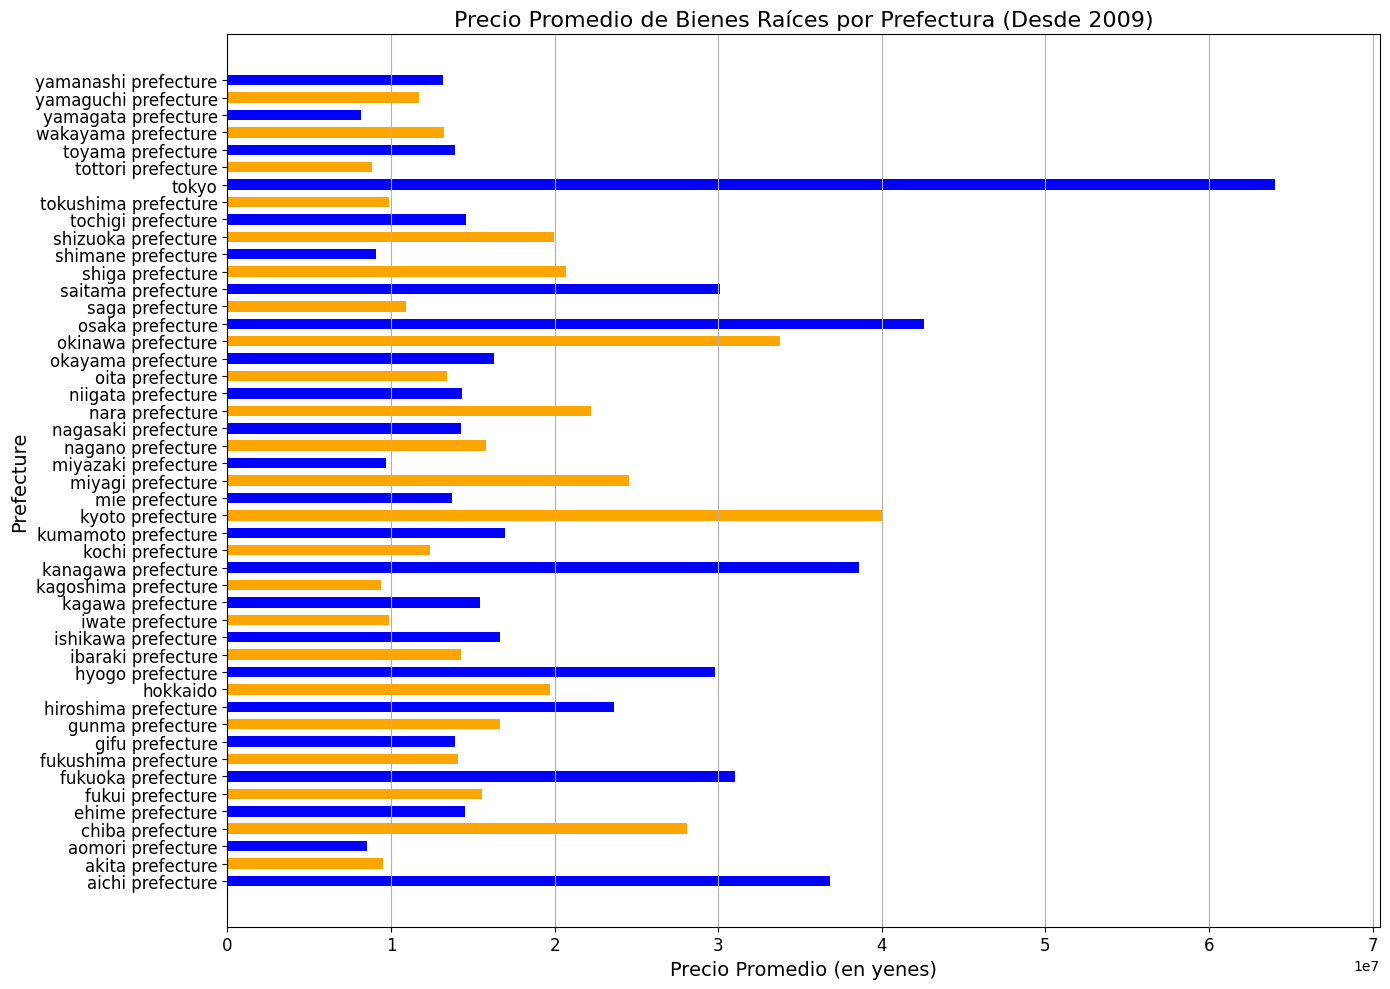

In [19]:
plt.figure(figsize=(14, 10))  
plt.barh(df_prefecture["Prefecture"], df_prefecture["TradePrice"], color=['blue', 'orange'], height=0.6) 
plt.title("Precio Promedio de Bienes Raíces por Prefectura (Desde 2009)", fontsize=16)
plt.xlabel("Precio Promedio (en yenes)", fontsize=14)
plt.ylabel("Prefecture", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  
plt.xlim(0, df_prefecture["TradePrice"].max() * 1.1) 
plt.grid(axis='x')
plt.tight_layout()  
plt.show()

Are there any duplicates?
Over the EDA has been found row duplicates and data redundancy in out data set. Check other jupyter notebook for reference.